Course-level (program data)

This is absolutely worth it, but mainly for:

Better differentiation between similar institutions:
Two universities might look the same at institution-level (ENG_RATIO, cost, retention), but one has more engineering programs or lower typical debt in those programs. Your course-level file already contains that (DEBT_* fields by CIP, etc.). That’s extra signal your current model doesn’t see.

Better “story” for the user:
Your PPT explicitly talks about “Which stream at this college is the best fit?” and program-level outcomes (debt, earnings). 


Even if the ROC AUC only improves a bit, being able to say “this college has 8 engineering majors with relatively low debt” is a big win for the product.

For pure VALUE_LABEL prediction (affordable + good quality), course-level aggregates might give a modest metric bump, because QUALITY_SCORE and COSTT4_A already encode a lot. But they’re definitely useful as extra features and for the final ranking and explanation layer.

Location thing (radius filter)

This is less about improving ROC AUC and more about:

Hard constraints (“I only want colleges within 200 km of home”).

A weighted objective (“location = 4/5 importance”).

You wouldn’t usually feed a specific user’s lat/lon into the training ML model (since every user can have a different home), but you:

Use location for filtering + scoring at recommendation time.

Optionally include generic location features (REGION, LOCALE) in the ML model.

So:

Course-level data → can help model and product.

Location radius filter → mainly helps product (user-facing) + ranking, not model AUC.

2. How I’d think about incorporating them

If I were designing this:

Augment institution-level X with course aggregates
From merged_course_level.csv (already engineering-only), build per-UNITID features like:

ENG_PROG_COUNT = number of distinct engineering programs (CIPCODE nunique).

ENG_CRED_LEVELS = number of different credential levels (bachelor, master, etc.).

DEBT_ALL_STGP_ANY_MDN_mean/min/max = typical program-level debt stats for engineering.
Then merge onto your inst_df and include them as features in the VALUE_LABEL classifier.

Keep VALUE_LABEL definition as institution-level
Still define something like “affordable + high quality” from COSTT4_A and QUALITY_SCORE and possibly outcomes = target y. Don’t mix course-level into the label to avoid weird leakage.

Use location at serving time
Implement:

annotate_distance(df, user_lat, user_lon) → add DISTANCE_KM.

filter_by_radius(df, user_lat, user_lon, radius_km) → only nearby schools.
Then let your user give a location weight (0–5) and use DISTANCE_KM in the final USER_SCORE.

Multi-model comparison view
For each model (Logistic, RF, GB, KNN), after GridSearchCV:

Store cv_results_ into a DataFrame.

Plot a bar chart of mean CV ROC AUC for the top N hyperparameter combos.

Also plot a bar chart of test ROC AUC per model.

That last bit matches what you described: “graph for each model that shows how good each hps performed”.

3. Fresh notebook code: institution + course + location + CV graphs

Here’s a single big code block you can paste into a new notebook.

You’ll need:

Processed-MERGED2023_24_PP.csv (institution-level, like in your earlier notebook)

merged_course_level.csv (the file you just uploaded)

If the filenames differ, just change the two constants at the top.

Institution-level shape: (5650, 33)
Course-level shape: (121798, 71)
Dropped 2401 invalid UNITID rows from course_df.
Aggregated course-level shape: (2875, 8)
Merged df shape: (5650, 41)
Median COSTT4_A: 24517.0
Median QUALITY_SCORE: 0.3101671281203574
VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64
Using features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'MD_EARN_WNE_P10', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT', 'ENG_PROG_COUNT', 'ENG_CRED_LEVELS', 'DEBT_ALL_STGP_ANY_MDN_mean', 'DEBT_ALL_STGP_ANY_MDN_min', 'DEBT_ALL_STGP_ANY_MDN_max', 'DEBT_ALL_PP_ANY_MDN_mean', 'DEBT_ALL_PP_ANY_MDN_min', 'DEBT_ALL_PP_ANY_MDN_max']
Train size: 4520
Test size: 1130
Running LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for LogisticRegression:
{'clf__C': 1, 'c

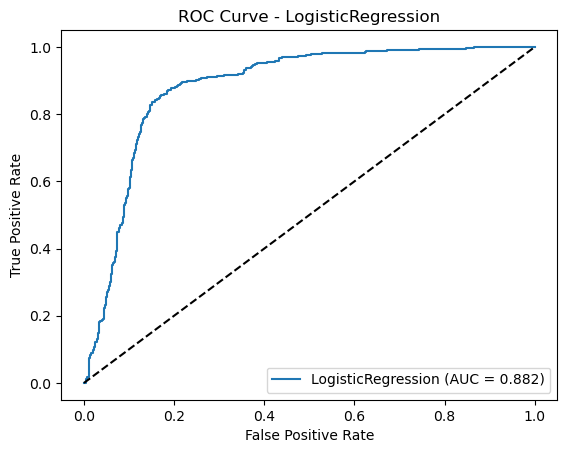

Running RandomForest
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best params for RandomForest:
{'clf__class_weight': 'balanced', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       780
           1       0.93      0.90      0.91       350

    accuracy                           0.95      1130
   macro avg       0.94      0.93      0.94      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9912087912087911
Confusion matrix:
[[756  24]
 [ 35 315]]


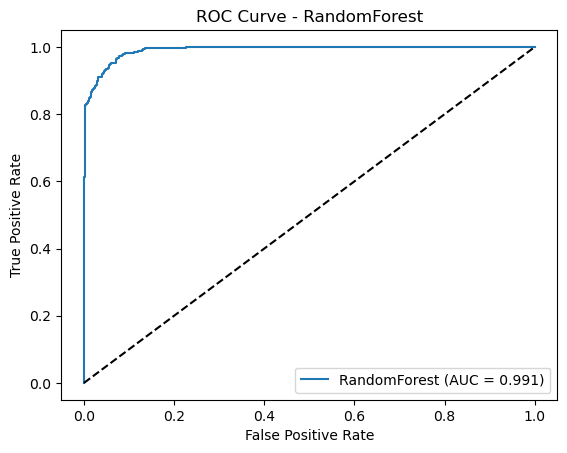

Running GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoosting:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       780
           1       0.93      0.92      0.93       350

    accuracy                           0.95      1130
   macro avg       0.95      0.94      0.95      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9912417582417583
Confusion matrix:
[[756  24]
 [ 28 322]]


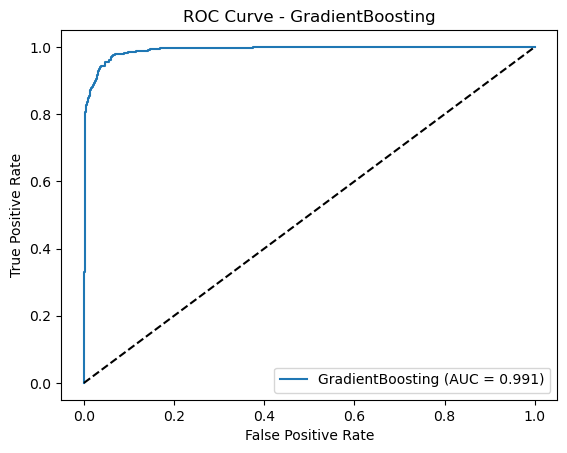

Running KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best params for KNN:
{'clf__n_neighbors': 15, 'clf__weights': 'distance'}
Best CV ROC AUC: 0.931

Test classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       780
           1       0.79      0.73      0.76       350

    accuracy                           0.86      1130
   macro avg       0.84      0.82      0.83      1130
weighted avg       0.85      0.86      0.85      1130

Test ROC AUC: 0.934139194139194
Confusion matrix:
[[714  66]
 [ 96 254]]


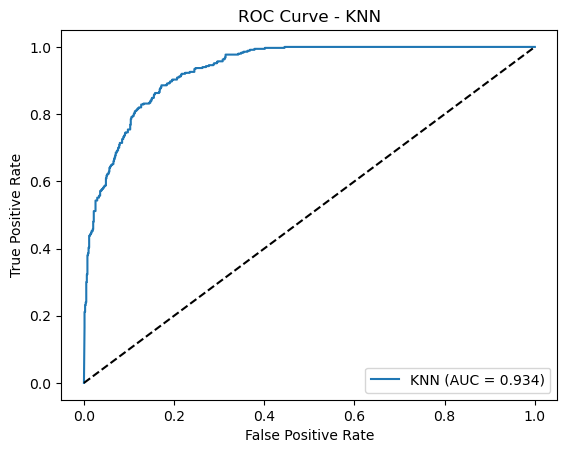

Running SVC
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params for SVC:
{'clf__C': 10, 'clf__class_weight': None, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV ROC AUC: 0.958

Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       780
           1       0.84      0.87      0.86       350

    accuracy                           0.91      1130
   macro avg       0.89      0.90      0.89      1130
weighted avg       0.91      0.91      0.91      1130

Test ROC AUC: 0.9626886446886447
Confusion matrix:
[[722  58]
 [ 45 305]]


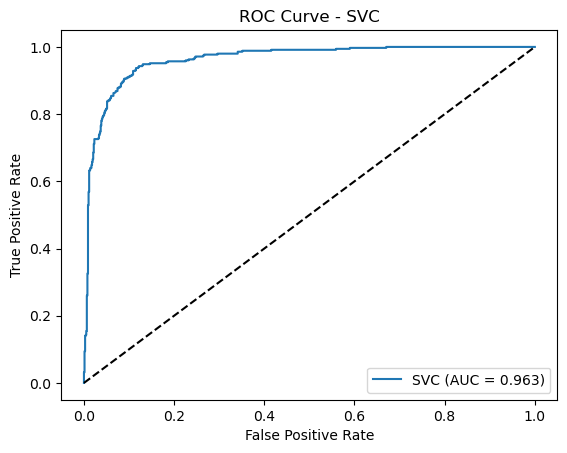

Selected main value model: RandomForest (CV ROC AUC = 0.993, test ROC AUC = 0.991)
Running RandomForestRegressor
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best params for RandomForestRegressor:
{'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV R²: 0.997

Test R²: 0.9937673453518358
Test RMSE: 0.0039751566867138695


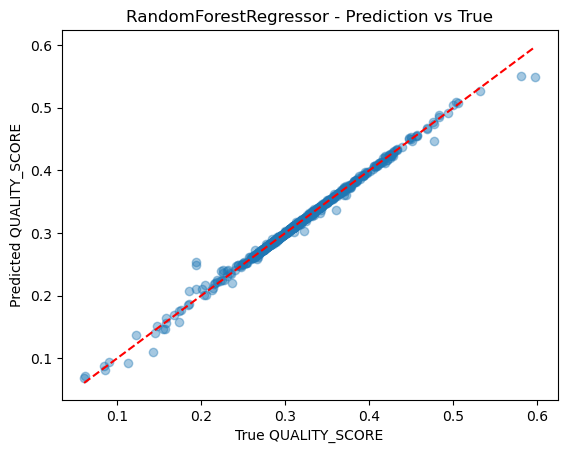

Running GradientBoostingRegressor
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoostingRegressor:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best CV R²: 0.998

Test R²: 0.9945413570161962
Test RMSE: 0.0037201466936180047


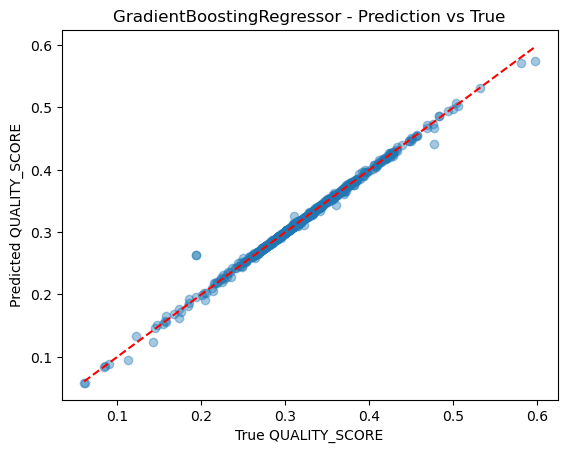

Running ElasticNet
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best params for ElasticNet:
{'clf__alpha': 0.01, 'clf__l1_ratio': 0.1}
Best CV R²: 0.999

Test R²: 0.9988934037929473
Test RMSE: 0.0016749903476759676


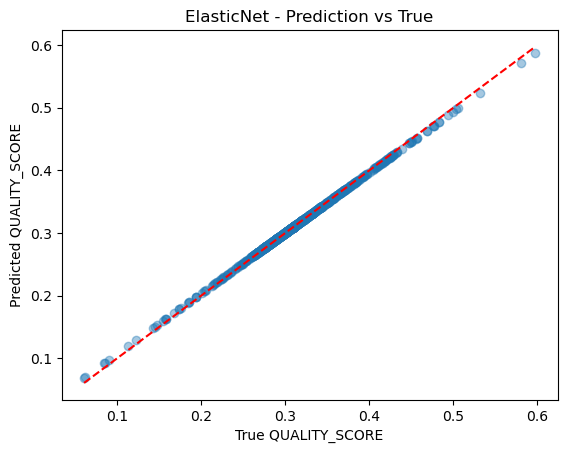

Running SVR
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best params for SVR:
{'clf__C': 1, 'clf__epsilon': 0.01, 'clf__gamma': 'auto'}
Best CV R²: 0.929

Test R²: 0.9166984094614493
Test RMSE: 0.014532635031926148


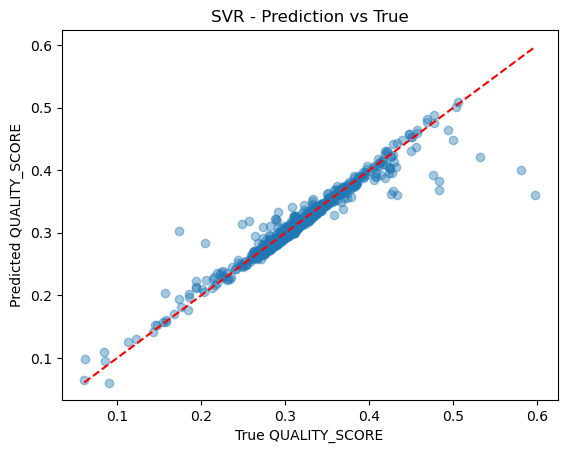

Selected main regression model: ElasticNet (CV R² = 0.999, test R² = 0.999, test RMSE = 0.002)


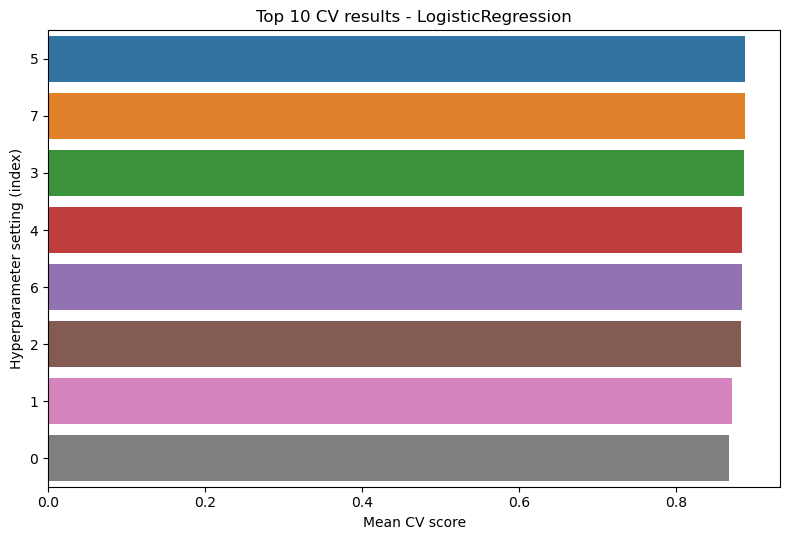

,mean_test_score,std_test_score,params
5,0.887689,0.006006,"{'clf__C': 1, 'clf__class_weight': 'balanced'}"
7,0.887630,0.006044,"{'clf__C': 10, 'clf__class_weight': 'balanced'}"
3,0.886296,0.006034,"{'clf__C': 0.1, 'clf__class_weight': 'balanced'}"
4,0.884133,0.006001,"{'clf__C': 1, 'clf__class_weight': None}"
6,0.884132,0.006052,"{'clf__C': 10, 'clf__class_weight': None}"
2,0.882902,0.006079,"{'clf__C': 0.1, 'clf__class_weight': None}"
1,0.870345,0.006649,"{'clf__C': 0.01, 'clf__class_weight': 'balanced'}"
0,0.867212,0.007212,"{'clf__C': 0.01, 'clf__class_weight': None}"


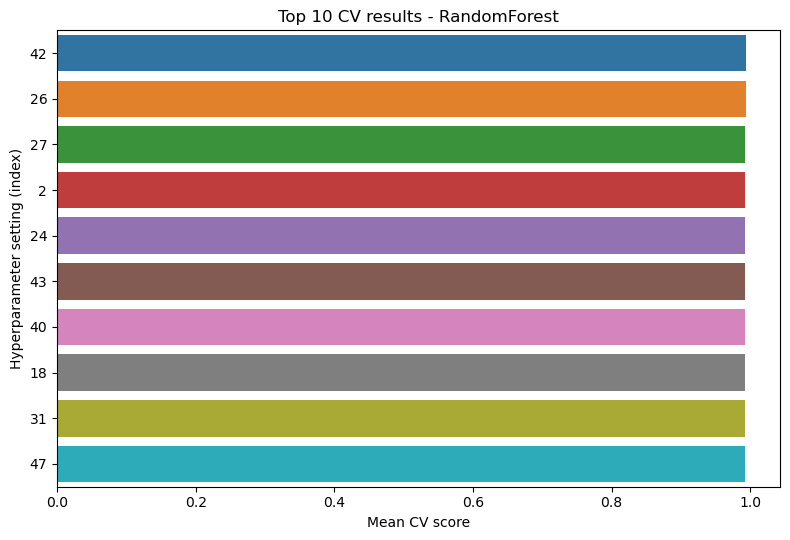

,mean_test_score,std_test_score,params
42,0.993143,0.001832,"{'clf__class_weight': 'balanced', 'clf__max_de..."
26,0.993126,0.001877,"{'clf__class_weight': 'balanced', 'clf__max_de..."
27,0.993024,0.001834,"{'clf__class_weight': 'balanced', 'clf__max_de..."
2,0.993015,0.001934,"{'clf__class_weight': None, 'clf__max_depth': ..."
24,0.993014,0.001822,"{'clf__class_weight': 'balanced', 'clf__max_de..."
43,0.993003,0.001822,"{'clf__class_weight': 'balanced', 'clf__max_de..."
40,0.992998,0.001801,"{'clf__class_weight': 'balanced', 'clf__max_de..."
18,0.992978,0.001879,"{'clf__class_weight': None, 'clf__max_depth': ..."
31,0.992962,0.001768,"{'clf__class_weight': 'balanced', 'clf__max_de..."
47,0.992948,0.001732,"{'clf__class_weight': 'balanced', 'clf__max_de..."


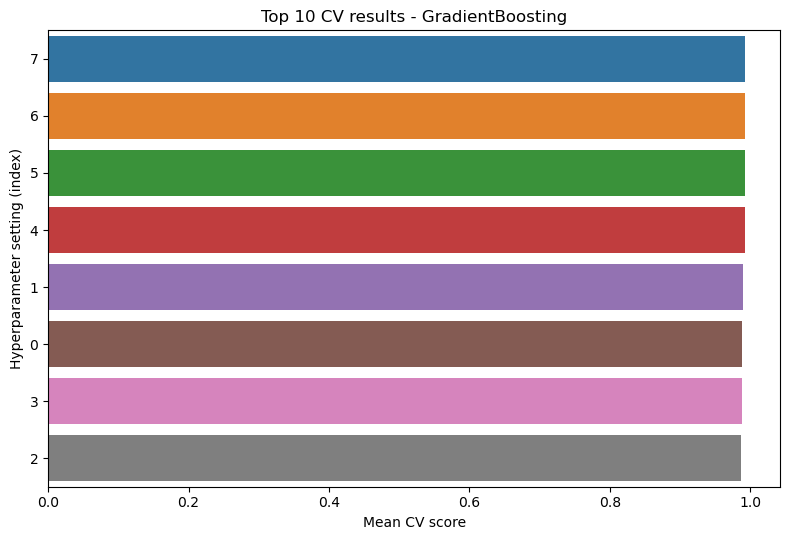

,mean_test_score,std_test_score,params
7,0.992643,0.002621,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
6,0.991889,0.003891,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
5,0.991820,0.002896,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
4,0.991818,0.003164,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
1,0.990273,0.003401,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
0,0.988460,0.003420,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
3,0.988237,0.007497,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
2,0.987126,0.007279,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."


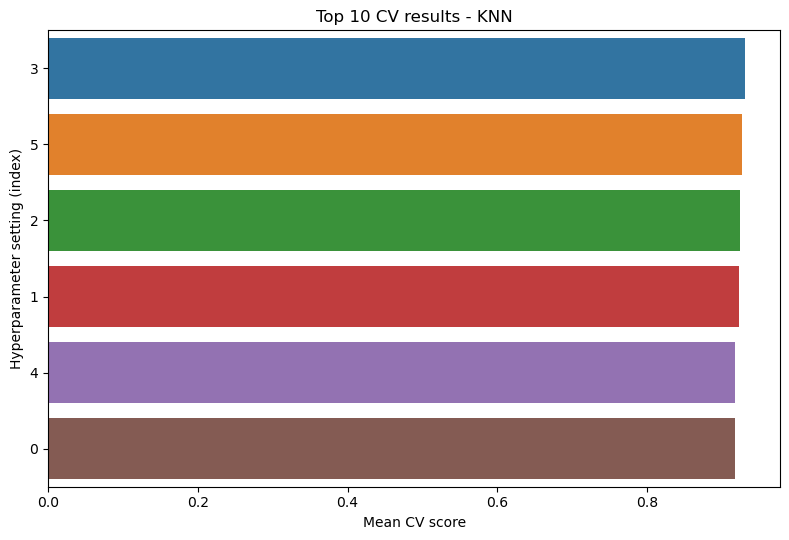

,mean_test_score,std_test_score,params
3,0.931082,0.008541,"{'clf__n_neighbors': 15, 'clf__weights': 'dist..."
5,0.926813,0.010279,"{'clf__n_neighbors': 25, 'clf__weights': 'dist..."
2,0.924619,0.008775,"{'clf__n_neighbors': 15, 'clf__weights': 'unif..."
1,0.922240,0.009598,"{'clf__n_neighbors': 5, 'clf__weights': 'dista..."
4,0.917801,0.010457,"{'clf__n_neighbors': 25, 'clf__weights': 'unif..."
0,0.917296,0.009579,"{'clf__n_neighbors': 5, 'clf__weights': 'unifo..."


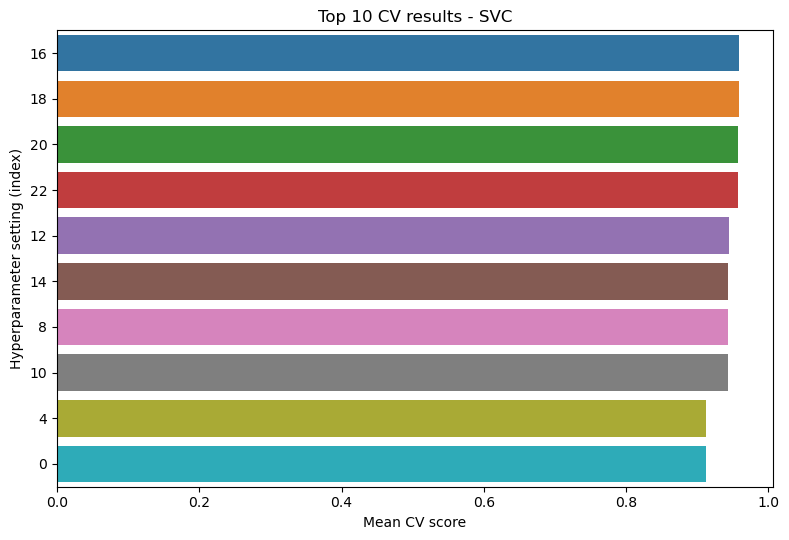

,mean_test_score,std_test_score,params
16,0.958426,0.002757,"{'clf__C': 10, 'clf__class_weight': None, 'clf..."
18,0.958136,0.002707,"{'clf__C': 10, 'clf__class_weight': None, 'clf..."
20,0.957455,0.003821,"{'clf__C': 10, 'clf__class_weight': 'balanced'..."
22,0.957389,0.004019,"{'clf__C': 10, 'clf__class_weight': 'balanced'..."
12,0.944328,0.004740,"{'clf__C': 1, 'clf__class_weight': 'balanced',..."
14,0.943738,0.004811,"{'clf__C': 1, 'clf__class_weight': 'balanced',..."
8,0.943558,0.004786,"{'clf__C': 1, 'clf__class_weight': None, 'clf_..."
10,0.943285,0.004563,"{'clf__C': 1, 'clf__class_weight': None, 'clf_..."
4,0.912232,0.006247,"{'clf__C': 0.1, 'clf__class_weight': 'balanced..."
0,0.911857,0.005216,"{'clf__C': 0.1, 'clf__class_weight': None, 'cl..."


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


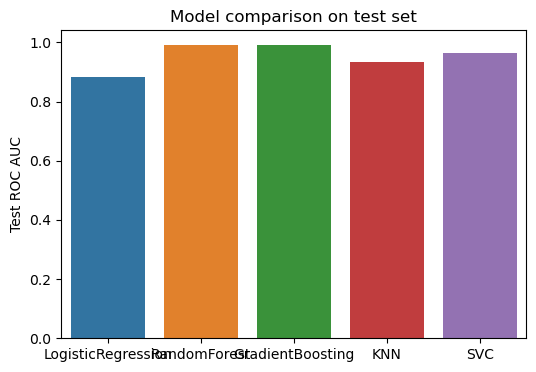

,UNITID,INSTNM,CITY,STABBR,LATITUDE,LONGITUDE,PCIP14,PCIP15,ENG_TOTAL,ENG_RATIO,...,eng_score,earnings_score,research_score,prog_count_score,debt_score,location_score,sector_indicator,SECTOR,USER_SCORE,ADM_BUCKET
5015,484473,University of Florida-Online,Gainesville,FL,29.649413,-82.339848,0.0000,0.0000,0.0000,0.000000,...,0.000000,0.467450,0.699527,0.484848,0.725752,0.995085,1.0,Public,0.673933,Medium admit (30-70%)
635,137209,Seminole State College of Florida,Sanford,FL,28.745482,-81.308003,0.0000,0.0811,0.0811,0.081092,...,0.081092,0.245962,0.487766,0.242424,0.725940,0.529867,1.0,Public,0.627054,High admit (>=70%)
640,137351,University of South Florida,Tampa,FL,28.061458,-82.413232,0.0567,0.0000,0.0567,0.056706,...,0.056706,0.364737,0.636206,0.333333,0.705468,0.409916,1.0,Public,0.611488,Medium admit (30-70%)
586,134495,Hillsborough Community College,Tampa,FL,27.934888,-82.456253,0.0000,0.0141,0.0141,0.014101,...,0.014101,0.238907,0.484181,0.212121,0.791890,0.362270,1.0,Public,0.607860,High admit (>=70%)
614,136172,University of North Florida,Jacksonville,FL,30.271940,-81.509144,0.0439,0.0170,0.0609,0.060906,...,0.060906,0.354351,0.575480,0.090909,0.651256,0.651478,1.0,Public,0.604953,Medium admit (30-70%)
552,132903,University of Central Florida,Orlando,FL,28.602159,-81.200889,0.0833,0.0000,0.0833,0.083300,...,0.083300,0.368929,0.642227,0.333333,0.660555,0.467350,1.0,Public,0.598071,Medium admit (30-70%)
578,134097,Florida State University,Tallahassee,FL,30.443147,-84.295064,0.0385,0.0000,0.0385,0.038504,...,0.038504,0.393908,0.673726,0.212121,0.707609,0.303114,1.0,Public,0.597068,Low admit (<30%)
579,134130,University of Florida,Gainesville,FL,29.646290,-82.347911,0.1285,0.0099,0.1384,0.138414,...,0.138414,0.467450,0.718929,0.484848,0.701393,0.992300,1.0,Public,0.595465,Low admit (<30%)
653,138187,Valencia College,Orlando,FL,28.520783,-81.464275,0.0000,0.0228,0.0228,0.022798,...,0.022798,0.237512,0.483472,0.212121,0.703198,0.496650,1.0,Public,0.589063,High admit (>=70%)
4788,476063,Tulsa Welding School-Jacksonville,Jacksonville,FL,30.313564,-81.560070,0.0000,0.3472,0.3472,0.347200,...,0.347200,0.241021,0.485255,0.030303,0.897033,0.652903,0.5,For-profit,0.587677,High admit (>=70%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score,
)

from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from IPython.display import display

# -------------------------------------------------------------------
# 1. Paths & basic config
# -------------------------------------------------------------------

INSTITUTION_CSV = "../data/institute_most_recent_processed.csv"
COURSE_CSV      = "../data/merged_course_level.csv"

# -------------------------------------------------------------------
# 2. Load & merge institution-level and course-level features
# -------------------------------------------------------------------

inst_df = pd.read_csv(INSTITUTION_CSV)
course_df = pd.read_csv(COURSE_CSV, low_memory=False)

print("Institution-level shape:", inst_df.shape)
print("Course-level shape:", course_df.shape)

# Make UNITID a consistent integer key
inst_df["UNITID"] = pd.to_numeric(inst_df["UNITID"], errors="coerce")
inst_df = inst_df.dropna(subset=["UNITID"])
inst_df["UNITID"] = inst_df["UNITID"].astype(int)

course_df["UNITID"] = pd.to_numeric(course_df["UNITID"], errors="coerce")
before = len(course_df)
course_df = course_df.dropna(subset=["UNITID"])
after = len(course_df)
print(f"Dropped {before - after} invalid UNITID rows from course_df.")
course_df["UNITID"] = course_df["UNITID"].astype(int)

# -------------------------------------------------------------------
# 3. Aggregate course-level features to institution level
# -------------------------------------------------------------------

agg_cols = [
    "DEBT_ALL_STGP_ANY_MDN",
    "DEBT_ALL_PP_ANY_MDN",
]

for col in agg_cols:
    if col not in course_df.columns:
        print(f"Warning: {col} not found in course-level data")
    else:
        course_df[col] = pd.to_numeric(course_df[col], errors="coerce")

base_cols_for_course = ["UNITID", "CIPCODE", "CREDLEV"]
course_df_subset_cols = base_cols_for_course + [c for c in agg_cols if c in course_df.columns]
course_df_subset = course_df[course_df_subset_cols].copy()

agg_dict = {
    "CIPCODE": "nunique",
    "CREDLEV": "nunique",
}
if "DEBT_ALL_STGP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_STGP_ANY_MDN"] = ["mean", "min", "max"]
if "DEBT_ALL_PP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_PP_ANY_MDN"] = ["mean", "min", "max"]

course_agg = course_df_subset.groupby("UNITID").agg(agg_dict)
course_agg.columns = [
    "_".join([str(c) for c in col if c]) if isinstance(col, tuple) else col
    for col in course_agg.columns
]
course_agg = course_agg.rename(columns={
    "CIPCODE_nunique": "ENG_PROG_COUNT",
    "CREDLEV_nunique": "ENG_CRED_LEVELS",
})

print("Aggregated course-level shape:", course_agg.shape)

df = inst_df.merge(course_agg, on="UNITID", how="left")
print("Merged df shape:", df.shape)

# -------------------------------------------------------------------
# 4. Define target label (VALUE_LABEL) and feature set
# -------------------------------------------------------------------

cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()
print("Median COSTT4_A:", cost_med)
print("Median QUALITY_SCORE:", quality_med)

df["VALUE_LABEL"] = (
    (df["COSTT4_A"] <= cost_med) &
    (df["QUALITY_SCORE"] >= quality_med)
).astype(int)

print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))

base_features = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "MD_EARN_WNE_P10",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]
course_features = [
    "ENG_PROG_COUNT", "ENG_CRED_LEVELS",
    "DEBT_ALL_STGP_ANY_MDN_mean",
    "DEBT_ALL_STGP_ANY_MDN_min",
    "DEBT_ALL_STGP_ANY_MDN_max",
    "DEBT_ALL_PP_ANY_MDN_mean",
    "DEBT_ALL_PP_ANY_MDN_min",
    "DEBT_ALL_PP_ANY_MDN_max",
]
feature_cols = [c for c in (base_features + course_features) if c in df.columns]
print("Using features:", feature_cols)

df_model = df.dropna(subset=["VALUE_LABEL"])
X = df_model[feature_cols]
y = df_model["VALUE_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# -------------------------------------------------------------------
# 5. Global min/max stats for stable scoring
# -------------------------------------------------------------------

debt_cols = [c for c in df_model.columns if "DEBT_ALL_STGP_ANY_MDN" in c or "DEBT_ALL_PP_ANY_MDN" in c]
if debt_cols:
    df_model["DEBT_AGG_MEAN"] = df_model[debt_cols].mean(axis=1)

norm_stats = {}
for col in [
    "COSTT4_A",
    "ENG_RATIO",
    "MD_EARN_WNE_P10",
    "QUALITY_SCORE",
    "ENG_PROG_COUNT",
    "DEBT_AGG_MEAN",
]:
    if col in df_model.columns:
        col_min = df_model[col].min()
        col_max = df_model[col].max()
        if col_max == col_min:
            col_max = col_min + 1e-9
        norm_stats[col] = (col_min, col_max)


def minmax_with_stats(series, stats):
    mn, mx = stats
    denom = mx - mn
    return (series - mn) / (denom if denom > 0 else 1e-9)

# -------------------------------------------------------------------
# 6. Location helper functions
# -------------------------------------------------------------------

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1_r = np.radians(lat1)
    lon1_r = np.radians(lon1)
    lat2_r = np.radians(lat2)
    lon2_r = np.radians(lon2)
    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r
    a = np.sin(dlat/2.0)**2 + np.cos(lat1_r)*np.cos(lat2_r)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def annotate_distance(df_in, user_lat, user_lon):
    df_loc = df_in.copy()
    if not {"LATITUDE", "LONGITUDE"} <= set(df_loc.columns):
        return df_loc
    distances = haversine_distance(
        user_lat, user_lon,
        df_loc["LATITUDE"].values,
        df_loc["LONGITUDE"].values
    )
    df_loc["DISTANCE_KM"] = distances
    return df_loc

def filter_by_radius(df_in, user_lat, user_lon, radius_km):
    df_with_dist = annotate_distance(df_in, user_lat, user_lon)
    if "DISTANCE_KM" not in df_with_dist.columns:
        return df_with_dist
    return df_with_dist[df_with_dist["DISTANCE_KM"] <= radius_km]

# -------------------------------------------------------------------
# 7. Multi-model classification with GridSearchCV
# -------------------------------------------------------------------

classifiers = {}

log_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])
log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}
classifiers["LogisticRegression"] = (log_reg_pipe, log_reg_param_grid)

rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=42))
])
rf_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__class_weight": [None, "balanced"]
}
classifiers["RandomForest"] = (rf_pipe, rf_param_grid)

gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])
gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5]
}
classifiers["GradientBoosting"] = (gb_pipe, gb_param_grid)

knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])
knn_param_grid = {
    "clf__n_neighbors": [5, 15, 25],
    "clf__weights": ["uniform", "distance"]
}
classifiers["KNN"] = (knn_pipe, knn_param_grid)

svc_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])
svc_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf", "linear"],
    "clf__class_weight": [None, "balanced"]
}
classifiers["SVC"] = (svc_pipe, svc_param_grid)

best_classifiers = {}
cv_results_dict = {}
test_metrics = {}
cv_best_scores = {}

for name, (pipe, param_grid) in classifiers.items():
    print("="*80)
    print(f"Running {name}")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV ROC AUC: {grid.best_score_:.3f}")

    cv_best_scores[name] = grid.best_score_

    best_model = grid.best_estimator_
    best_classifiers[name] = best_model

    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_dict[name] = cv_results

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    print("\nTest classification report:")
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print("Test ROC AUC:", auc)
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    test_metrics[name] = {"roc_auc": auc}

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

best_model_name = max(cv_best_scores, key=cv_best_scores.get)
value_model = best_classifiers[best_model_name]
print(
    f"Selected main value model: {best_model_name} "
    f"(CV ROC AUC = {cv_best_scores[best_model_name]:.3f}, "
    f"test ROC AUC = {test_metrics[best_model_name]['roc_auc']:.3f})"
)

# -------------------------------------------------------------------
# 8. Regression models (QUALITY_SCORE) with GridSearchCV
# -------------------------------------------------------------------

regressors = {}

rf_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestRegressor(random_state=42))
])
rf_reg_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
}
regressors["RandomForestRegressor"] = (rf_reg, rf_reg_grid)

gb_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingRegressor(random_state=42))
])
gb_reg_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5],
}
regressors["GradientBoostingRegressor"] = (gb_reg, gb_reg_grid)

en_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", ElasticNet(max_iter=5000))
])
en_reg_grid = {
    "clf__alpha": [0.01, 0.1, 1.0, 10.0],
    "clf__l1_ratio": [0.1, 0.5, 0.9],
}
regressors["ElasticNet"] = (en_reg, en_reg_grid)

svr_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVR())
])
svr_reg_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__epsilon": [0.01, 0.1, 0.2],
}
regressors["SVR"] = (svr_reg, svr_reg_grid)

# Regression dataset
reg_df = df.dropna(subset=["QUALITY_SCORE"])
X_reg = reg_df[feature_cols]
y_reg = reg_df["QUALITY_SCORE"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

best_regressors = {}
reg_cv_best_scores = {}
reg_test_metrics = {}

for name, (pipe, param_grid) in regressors.items():
    print("="*80)
    print(f"Running {name}")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="r2",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(Xr_train, yr_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV R²: {grid.best_score_:.3f}")

    reg_cv_best_scores[name] = grid.best_score_

    best_model = grid.best_estimator_
    best_regressors[name] = best_model

    yr_pred = best_model.predict(Xr_test)
    r2 = r2_score(yr_test, yr_pred)
    rmse = mean_squared_error(yr_test, yr_pred, squared=False)

    print("\nTest R²:", r2)
    print("Test RMSE:", rmse)

    reg_test_metrics[name] = {"r2": r2, "rmse": rmse}

    plt.figure()
    plt.scatter(yr_test, yr_pred, alpha=0.4)
    plt.xlabel("True QUALITY_SCORE")
    plt.ylabel("Predicted QUALITY_SCORE")
    plt.title(f"{name} - Prediction vs True")
    plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], "r--")
    plt.show()

best_reg_name = max(reg_cv_best_scores, key=reg_cv_best_scores.get)
quality_model = best_regressors[best_reg_name]
print(
    f"Selected main regression model: {best_reg_name} "
    f"(CV R² = {reg_cv_best_scores[best_reg_name]:.3f}, "
    f"test R² = {reg_test_metrics[best_reg_name]['r2']:.3f}, "
    f"test RMSE = {reg_test_metrics[best_reg_name]['rmse']:.3f})"
)

# -------------------------------------------------------------------
# 9. Plot CV performance for each model (hyperparameter combos)
# -------------------------------------------------------------------

def plot_cv_performance(cv_results, model_name, top_n=10):
    df_cv = cv_results.copy()
    df_cv = df_cv.sort_values("mean_test_score", ascending=False).head(top_n)
    plt.figure(figsize=(8, 4 + top_n * 0.15))
    sns.barplot(data=df_cv, x="mean_test_score", y=df_cv.index.astype(str), orient="h")
    plt.xlabel("Mean CV score")
    plt.ylabel("Hyperparameter setting (index)")
    plt.title(f"Top {top_n} CV results - {model_name}")
    plt.tight_layout()
    plt.show()
    display(df_cv[["mean_test_score", "std_test_score", "params"]])

for name, cv_res in cv_results_dict.items():
    plot_cv_performance(cv_res, name, top_n=10)

plt.figure(figsize=(6, 4))
names = list(test_metrics.keys())
scores = [test_metrics[m]["roc_auc"] for m in names]
sns.barplot(x=names, y=scores)
plt.ylabel("Test ROC AUC")
plt.title("Model comparison on test set")
plt.show()

# -------------------------------------------------------------------
# 10. Ranking function with user weights (course-level + location)
# -------------------------------------------------------------------

def admission_bucket(adm):
    if pd.isna(adm):
        return "Unknown"
    if adm >= 0.70:
        return "High admit (>=70%)"
    if adm >= 0.30:
        return "Medium admit (30-70%)"
    return "Low admit (<30%)"

def rank_colleges_for_user(
    df_raw,
    feature_cols,
    value_model,
    user_weights,
    norm_stats,
    user_lat=None,
    user_lon=None,
    radius_km=None,
    preferred_state=None
):
    df_scored = df_raw.copy()

    if (user_lat is not None) and (user_lon is not None) and (radius_km is not None):
        df_scored = filter_by_radius(df_scored, user_lat, user_lon, radius_km)

    X_all = df_scored[feature_cols]
    p_value = value_model.predict_proba(X_all)[:, 1]
    df_scored["p_value_model"] = p_value

    def score_with_stats(col_name, out_col, invert=False):
        if col_name in df_scored.columns and col_name in norm_stats:
            vals = minmax_with_stats(df_scored[col_name].astype(float), norm_stats[col_name])
            df_scored[out_col] = 1 - vals if invert else vals
        else:
            df_scored[out_col] = 0.5

    score_with_stats("COSTT4_A", "cost_score", invert=True)
    score_with_stats("ENG_RATIO", "eng_score")
    score_with_stats("MD_EARN_WNE_P10", "earnings_score")
    score_with_stats("QUALITY_SCORE", "research_score")
    score_with_stats("ENG_PROG_COUNT", "prog_count_score")

    debt_cols_present = [c for c in df_scored.columns if "DEBT_ALL_STGP_ANY_MDN" in c or "DEBT_ALL_PP_ANY_MDN" in c]
    if debt_cols_present:
        debt_raw = df_scored[debt_cols_present].mean(axis=1)
        if "DEBT_AGG_MEAN" in norm_stats:
            vals = minmax_with_stats(debt_raw, norm_stats["DEBT_AGG_MEAN"])
            df_scored["debt_score"] = 1 - vals
        else:
            df_scored["debt_score"] = 1 - minmax_with_stats(debt_raw, (debt_raw.min(), debt_raw.max()))
    else:
        df_scored["debt_score"] = 0.5

    if "DISTANCE_KM" in df_scored.columns and radius_km is not None and radius_km > 0:
        df_scored["location_score"] = 1 - (df_scored["DISTANCE_KM"] / radius_km).clip(0, 1)
    elif preferred_state is not None and "STABBR" in df_scored.columns:
        df_scored["location_score"] = (df_scored["STABBR"] == preferred_state).astype(float)
    else:
        df_scored["location_score"] = 0.5

    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        sector_indicator = np.where(
            df_scored["IS_PUBLIC"] == 1, 1.0,
            np.where(df_scored["IS_PRIVATE"] == 1, 0.0, 0.5)
        )
    else:
        sector_indicator = np.full(len(df_scored), 0.5)
    df_scored["sector_indicator"] = sector_indicator

    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        df_scored["SECTOR"] = np.select(
            [
                df_scored["IS_PUBLIC"] == 1,
                df_scored["IS_PRIVATE"] == 1,
                df_scored["IS_FORPROFIT"] == 1
            ],
            ["Public", "Private", "For-profit"],
            default="Other"
        )
    else:
        df_scored["SECTOR"] = "Unknown"

    w_value   = user_weights.get("value_model", 0)
    w_cost    = user_weights.get("cost", 0)
    w_eng     = user_weights.get("engineering", 0)
    w_earn    = user_weights.get("earnings", 0)
    w_loc     = user_weights.get("location", 0)
    w_research = user_weights.get("research", 0)
    w_prog    = user_weights.get("program_count", 0)
    w_debt    = user_weights.get("debt", 0)
    w_public  = user_weights.get("prefer_public", 0)
    w_private = user_weights.get("prefer_private", 0)

    sector_component = (
        w_public  * df_scored["sector_indicator"] +
        w_private * (1 - df_scored["sector_indicator"])
    )

    total_w = (
        w_value + w_cost + w_eng + w_earn + w_loc +
        w_research + w_prog + w_debt + w_public + w_private
    )
    if total_w == 0:
        raise ValueError("All user weights are zero!")

    df_scored["USER_SCORE"] = (
        w_value * df_scored["p_value_model"] +
        w_cost  * df_scored["cost_score"] +
        w_eng   * df_scored["eng_score"] +
        w_earn  * df_scored["earnings_score"] +
        w_loc   * df_scored["location_score"] +
        w_research * df_scored["research_score"] +
        w_prog * df_scored["prog_count_score"] +
        w_debt * df_scored["debt_score"] +
        sector_component
    ) / total_w

    ranked = df_scored.sort_values("USER_SCORE", ascending=False)
    if "ADM_RATE" in df_scored.columns:
        ranked["ADM_BUCKET"] = df_scored["ADM_RATE"].apply(admission_bucket)
    return ranked

# -------------------------------------------------------------------
# 11. Example usage for ranking
# -------------------------------------------------------------------

example_weights = {
    "value_model": 5,
    "cost": 5,
    "engineering": 4,
    "earnings": 3,
    "research": 4,
    "program_count": 2,
    "debt": 3,
    "location": 2,
    "prefer_public": 3,
    "prefer_private": 0,
}

user_lat_example = 29.6516
user_lon_example = -82.3248
radius_km_example = 300

ranked_colleges = rank_colleges_for_user(
    df_raw=df,
    feature_cols=feature_cols,
    value_model=value_model,
    user_weights=example_weights,
    norm_stats=norm_stats,
    user_lat=user_lat_example,
    user_lon=user_lon_example,
    radius_km=radius_km_example,
    preferred_state=None,
)

ranked_colleges.head(20)


